In [1]:
from lambeq import BobcatParser, AtomicType, IQPAnsatz
from lambeq import Rewriter, remove_cups
from lambeq import Dataset, QuantumTrainer, SPSAOptimizer, NumpyModel, TketModel  
from lambeq.core.utils import flatten
#from discopy import grammar

#from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.qiskit import tk_to_qiskit, AerBackend

import os
import warnings
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

/home/jovyan/.qbraid/environments/womanium_go14xk/pyenv/lib/python3.9/site-packages/lambeq/text2diagram/ccg_parser.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [26]:
BATCH_SIZE = 30  ## batch size of training data if don't want to use full training dataset at once
EPOCHS = 400    ## number of epochs for training the model
SEED = 2

## Read in data

In [3]:
def read_data(filename):
    labels, sentence_pairs = [], []
    with open(filename) as f:
        for line in f:
            l = line.strip().split(',')
            labels.append([int(l[2]), 1-int(l[2])]) ## not sure why two labels are required
            sentence_pairs.append([l[0]]+ [l[1]])
            
    return labels, sentence_pairs

labels, sentence_pairs = read_data('datasets/MC1.txt')
train_labels1, train_data1 = labels[:80], sentence_pairs[:80]  # for now first 60 data set is used as training data
#dev_labels, dev_data = labels[60:80], sentence_pairs[60:80]  # next 20 data set is validation data
test_labels1, test_data1 = labels[80:], sentence_pairs[80:]    # rest is test data

In [4]:
train_data1[:5], train_labels1[:5], test_data1[:5], test_labels1[:5]

([['cook creates complicated dish',
   ' experienced chef prepares complicated dish'],
  ['skilful programmer creates code', ' devoted hacker writes code'],
  ['skilful cook creates meal', ' devoted hacker creates complicated code'],
  ['hacker writes code', ' skilful hacker creates code'],
  ['devoted hacker writes code', ' hacker writes complicated code']],
 [[1, 0], [1, 0], [0, 1], [1, 0], [1, 0]],
 [['devoted hacker creates complicated code',
   ' skilful cook prepares complicated meal'],
  ['chef creates complicated meal', ' cook prepares tasty dish'],
  ['chef prepares tasty meal', ' chef prepares meal'],
  ['programmer writes code', ' cook prepares complicated meal'],
  ['hacker writes advanced code', ' hacker creates code']],
 [[0, 1], [1, 0], [1, 0], [0, 1], [1, 0]])

In [5]:
## Create a random dataset from the given data by shuffling

sentence_pairs1, labels1  = Dataset.shuffle_data(sentence_pairs, labels) ## returns data, target

train_labels, train_data = labels1[:80], sentence_pairs1[:80]  # for now first 80 data set is used as training data
#dev_labels, dev_data = labels[60:80], sentence_pairs[60:80]  # next 20 data set is validation data
test_labels, test_data = labels1[80:], sentence_pairs1[80:]    # rest is test data

In [6]:
train_data[:5], train_labels[:5], test_data[:5], test_labels[:5]

([['chef creates tasty meal', ' skilful programmer writes advanced code'],
  ['devoted programmer creates complicated code', ' cook prepares tasty dish'],
  ['hacker creates code', ' programmer creates complicated code'],
  ['hacker creates code', ' skilful chef creates meal'],
  ['skilful chef creates tasty meal', ' skilful programmer creates code']],
 [[0, 1], [0, 1], [1, 0], [0, 1], [0, 1]],
 [['chef creates meal', ' skilful chef prepares tasty dish'],
  ['programmer writes code', ' skilful hacker writes advanced code'],
  ['devoted hacker writes complicated code', ' skilful chef creates dish'],
  ['programmer creates code', ' programmer creates advanced code'],
  ['programmer writes code', ' programmer writes code']],
 [[1, 0], [1, 0], [0, 1], [1, 0], [1, 0]])

## Create and check diagrams

In [7]:
parser = BobcatParser(verbose='suppress')  ## to select particular type of words like nouns use 'root_cats' parameter

raw_train_diagrams = [parser.sentences2diagrams(d) for d in train_data] # can send list of list of str to the function
#raw_dev_diagrams = [parser.sentences2diagrams(d) for d in dev_data]
raw_test_diagrams = [parser.sentences2diagrams(d) for d in test_data]

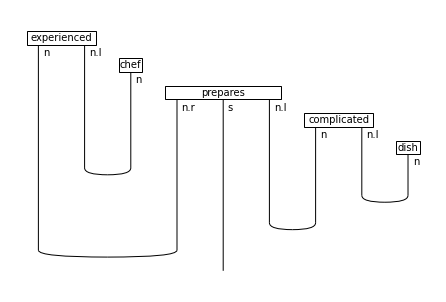

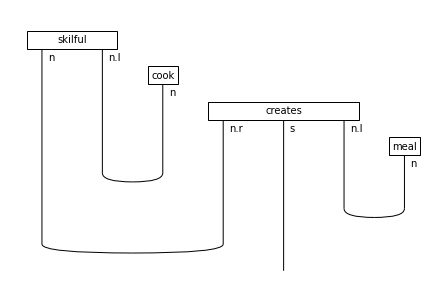

(['experienced chef prepares complicated dish', ' skilful cook creates meal'],
 None,
 None)

In [8]:
train_data[15], raw_train_diagrams[15][0].draw(), raw_train_diagrams[15][1].draw()

## Filter and simply string diagrams

In [9]:
## First filter out those diagrams which could not be parsed

## before filtering
#print(len(raw_train_diagrams), len(raw_dev_diagrams), len(raw_test_diagrams))

train_diagrams, train_labels_final = [], []
dev_diagrams, dev_labels_final = [], []
test_diagrams, test_labels_final = [], []

for diagram, label in zip(raw_train_diagrams, train_labels):
    if diagram[0] is not None and diagram[1] is not None:
        train_diagrams.append(remove_cups(diagram))
        train_labels_final.append(label)
        
# for diagram, label in zip(raw_dev_diagrams, dev_labels):
#     if diagram[0] is not None and diagram[1] is not None:
#         dev_diagrams.append(remove_cups(diagram))
#         dev_labels_final.append(label)

for diagram, label in zip(raw_test_diagrams, test_labels):
    if diagram[0] is not None and diagram[1] is not None:
        test_diagrams.append(remove_cups(diagram))
        test_labels_final.append(label)

print(len(train_diagrams), len(dev_diagrams), len(test_diagrams))

80 0 20


## Create circuits

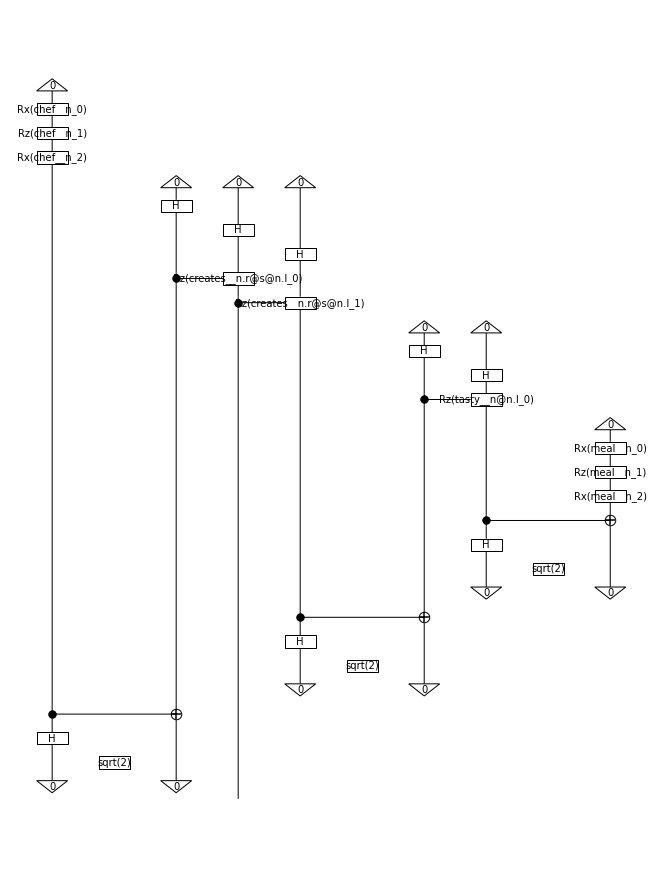

In [10]:
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3) 

train_circuits = [[ansatz(diagram[0]), ansatz(diagram[1])] for diagram in train_diagrams]
# dev_circuits =  [[ansatz(diagram[0]), ansatz(diagram[1])] for diagram in dev_diagrams]
test_circuits = [[ansatz(diagram[0]), ansatz(diagram[1])] for diagram in test_diagrams]

train_circuits[0][0].draw(figsize=(9, 12))

## Parameterise

In [27]:
## JAX backend

#all_circuits = train_circuits + dev_circuits + test_circuits
all_circuits = [d for d in flatten(train_circuits)] + [d for d in flatten(test_circuits)]

model = NumpyModel.from_diagrams(all_circuits, use_jit=True)
#model1 = NumpyModel.from_diagrams(train_circuits, use_jit=True) # cann't take list of list
#model1.initialise_weights()
#res = model1(all_circuits[:20])

In [18]:
## AerBackend
backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}
qmodel = TketModel.from_diagrams(all_circuits, backend_config=backend_config)
qmodel.make_checkpoint('datasets/qmodel_train_checkpoint')
#qmodel1 = TketModel.from_checkpoint('datasets/qmodel_train_checkpoint', backend_config=backend_config)

## Define Loss and accuracy functions

In [12]:
def loss_func(y_hat, y):
    ## tensor product and binary cross-entropy loss function
    y_hat_new  = []
    y_new = []
    for i in range(0, len(y_hat), 2):
        tns_pd = np.tensordot(y_hat[i], y_hat[i+1], axes=0)
        y_hat_new.append([tns_pd[0][0] + tns_pd[1][1], tns_pd[0][1] + tns_pd[1][0]])
        y_new.append(y[i])
        #print(np.sum(res_new[i]))
    loss =  -np.sum(np.array(y_new) * np.log(y_hat_new)) / len(y_new) # binary cross-entropy loss
    
    return loss

def accuracy_func(y_hat, y):
    y_hat_new  = []
    y_new = []
    for i in range(0, len(y_hat), 2):
        tns_pd = np.tensordot(y_hat[i], y_hat[i+1], axes=0)
        y_hat_new.append([tns_pd[0][0] + tns_pd[1][1], tns_pd[0][1] + tns_pd[1][0]])
        y_new.append(y[i])
    
    acc = np.sum(np.round(y_hat_new) == y_new) / len(y_new) / 2  # half due to double-counting
    
    return acc

## Define trainer and create Dataset

In [28]:
trainer = QuantumTrainer(
    model,
    loss_function=loss_func,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': accuracy_func},
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)

In [56]:
# trainerq = QuantumTrainer(
#     qmodel,
#     loss_function=loss_func,
#     epochs=EPOCHS,
#     optimizer=SPSAOptimizer,
#     optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
#     evaluate_functions={'acc': accuracy_func},
#     evaluate_on_train=True,
#     verbose = 'text',
#     seed=0
# )

In [15]:
train_dataset = Dataset([d for d in flatten(train_circuits)], np.repeat(train_labels, 2, axis=0),  batch_size=BATCH_SIZE*2, shuffle=False)

## Trian the model

In [29]:
trainer.fit(train_dataset, logging_step=20) 

Epoch 1:    train/loss: 0.6974   valid/loss: -----   train/acc: 0.4500   valid/acc: -----
Epoch 20:   train/loss: 0.6772   valid/loss: -----   train/acc: 0.5750   valid/acc: -----
Epoch 40:   train/loss: 0.6377   valid/loss: -----   train/acc: 0.6375   valid/acc: -----
Epoch 60:   train/loss: 0.6103   valid/loss: -----   train/acc: 0.7000   valid/acc: -----
Epoch 80:   train/loss: 0.5812   valid/loss: -----   train/acc: 0.7500   valid/acc: -----
Epoch 100:  train/loss: 0.5634   valid/loss: -----   train/acc: 0.8750   valid/acc: -----
Epoch 120:  train/loss: 0.5329   valid/loss: -----   train/acc: 0.9125   valid/acc: -----
Epoch 140:  train/loss: 0.5064   valid/loss: -----   train/acc: 0.9750   valid/acc: -----
Epoch 160:  train/loss: 0.4962   valid/loss: -----   train/acc: 0.9500   valid/acc: -----
Epoch 180:  train/loss: 0.4930   valid/loss: -----   train/acc: 0.9750   valid/acc: -----
Epoch 200:  train/loss: 0.4643   valid/loss: -----   train/acc: 0.9625   valid/acc: -----
Epoch 220:

## Plot the loss and accuracy during training, and check model prediction accuracy with test dataset

Test accuracy: 1.0


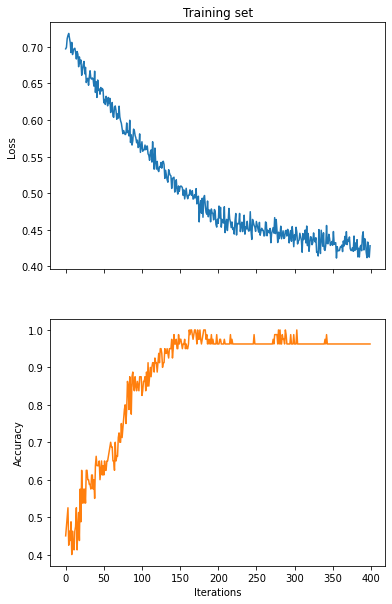

In [30]:
fig, (ax_t, ax_b) = plt.subplots(2, 1, sharex=True, sharey='row', figsize=(6, 10))
ax_t.set_title('Training set')
#ax_tr.set_title('Development set')
ax_b.set_xlabel('Iterations')
#ax_br.set_xlabel('Iterations')
ax_b.set_ylabel('Accuracy')
ax_t.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_t.plot(trainer.train_epoch_costs, color=next(colours))
ax_b.plot(trainer.train_results['acc'], color=next(colours))
#ax_tr.plot(trainer.val_costs, color=next(colours))
#ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = accuracy_func(model([d for d in flatten(test_circuits)]), np.repeat(test_labels, 2, axis=0))
print('Test accuracy:', test_acc)

## Check the circuit output for test dataset

In [31]:
y_hat, y = model([d for d in flatten(test_circuits)]), np.repeat(test_labels, 2, axis=0)

In [32]:
y_hat_new  = []
y_new = []
for i in range(0, len(y_hat), 2):
    tns_pd = np.tensordot(y_hat[i], y_hat[i+1], axes=0)
    y_hat_new.append([tns_pd[0][0] + tns_pd[1][1], tns_pd[0][1] + tns_pd[1][0]])
    y_new.append(y[i])

In [35]:
for i, r in enumerate(y_new):
    print(y_hat_new[i], r)

[0.74850756, 0.25149238] [1 0]
[0.7526822, 0.24731785] [1 0]
[0.34562972, 0.65437037] [0 1]
[0.81797194, 0.18202811] [1 0]
[0.6482606, 0.3517394] [1 0]
[0.5743997, 0.4256003] [1 0]
[0.16520265, 0.8347974] [0 1]
[0.41628015, 0.5837198] [0 1]
[0.7214439, 0.27855602] [1 0]
[0.5843838, 0.41561627] [1 0]
[0.86884075, 0.13115919] [1 0]
[0.26020423, 0.73979574] [0 1]
[0.6440382, 0.3559618] [1 0]
[0.41975996, 0.5802401] [0 1]
[0.3474806, 0.65251946] [0 1]
[0.0961707, 0.9038294] [0 1]
[0.4594704, 0.5405296] [0 1]
[0.36837724, 0.63162273] [0 1]
[0.5370196, 0.46298045] [1 0]
[0.65342104, 0.34657896] [1 0]
